### 1. 패키지 설치

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix

### 2. vagetable image dataset 다운로드

In [ ]:
# 구글 코랩에서 데이터셋 다운로드 및 준비
from google.colab import drive
drive.mount('/content/drive')

# # kaggle vagitable image 데이터셋 다운로드
!unzip '/content/drive/MyDrive/archive.zip' -d /content/dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0013.jpg  
  inflating: /content/dataset/Vegetable I

In [ ]:
# 학습(train), 테스트(test), 검증(validation) 데이터셋 경로 지정
train_dir = 'dataset/Vegetable Images/train'
test_dir = 'dataset/Vegetable Images/test'
val_dir = 'dataset/Vegetable Images/validation'

### 3. EDA(Exploratory Data Analysis)

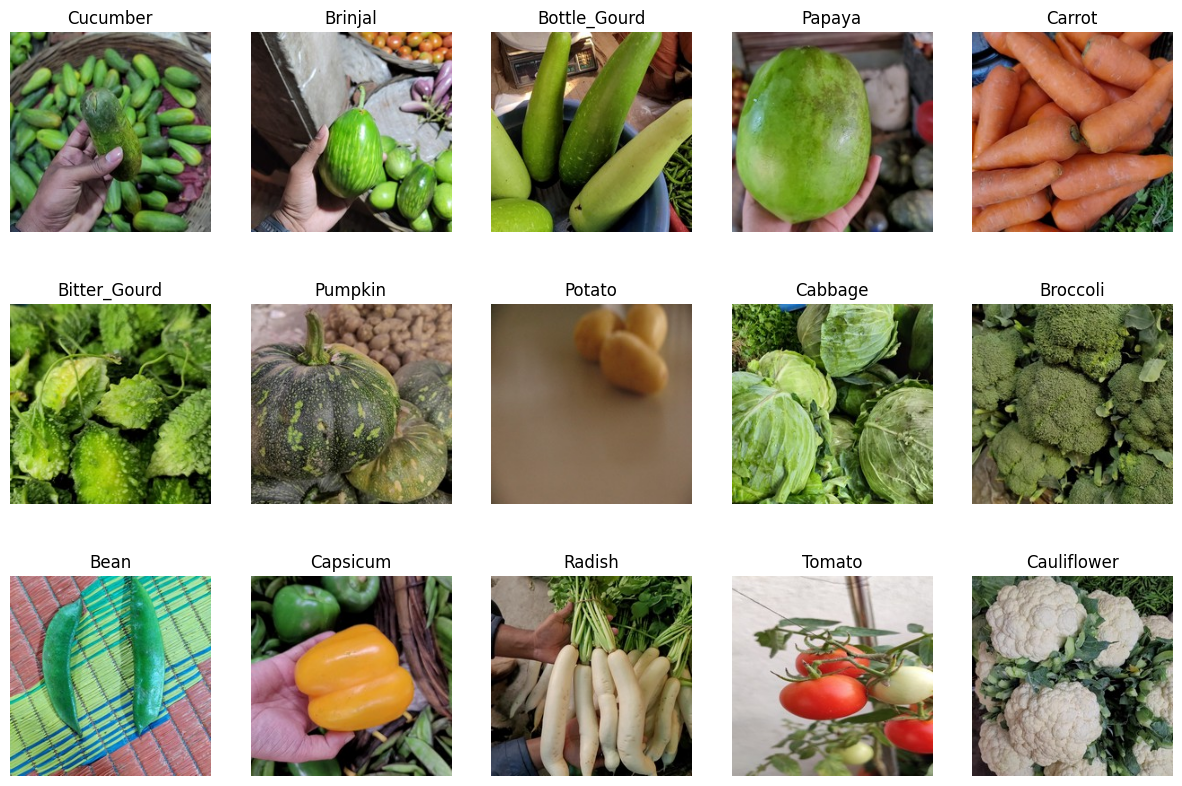

In [ ]:
# 데이터셋 이미지 시각화
image_dimensions = []

# 클래스 리스트 가져오기
clsses = os.listdir(train_dir)

plt.figure(figsize=(15, 10))

# 각 클래스와 이미지 표츌
for i, class_name in enumerate(clsses):
  class_dir = os.path.join(train_dir, class_name)
  images = os.listdir(class_dir)

  # 각 클래스에서 첫 번째 이미지 가져오기
  image_path = os.path.join(class_dir, images[0])
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # opencv의 brg색상을 cvtCOLOR를 활용하여 rgb로 변환

  # 이미지 형태 저장
  height, width, channels = image.shape
  image_dimensions.append((height, width, channels))

  # 이미지 시각화
  plt.subplot(3, 5, i+1)
  plt.imshow(image)
  plt.title(class_name)
  plt.axis('off')

# plt.show()

In [ ]:
# 이미지 크기 확인
df = pd.DataFrame(image_dimensions, columns=['Height', 'Width', 'Channels'])
df.describe().loc[['min', 'mean', 'max']]

,Height,Width,Channels
min,224.0,224.0,3.0
mean,224.0,224.0,3.0
max,224.0,224.0,3.0


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

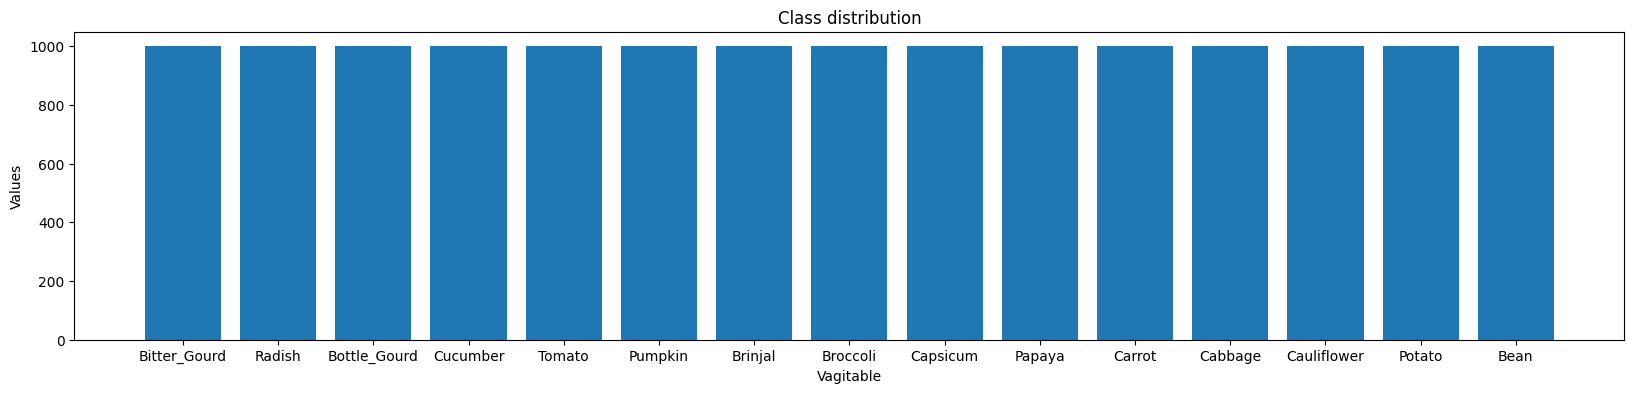

In [ ]:
# 클래스별 데이터셋 분포 확인
# 디렉토리 초기화
count_dict = {}

# 클래스명, 파일 갯수 저장
for root, dirs, files in os.walk(train_dir):
  clase = os.path.basename(root)
  count_dict[clase] = len(files)

lables = list(count_dict.keys())[1:] # 슬라이싱으로 클래스 첫 번째 항목부터 추출
values = list(count_dict.values())[1:]

plt.figure(figsize=(20, 4))
plt.bar(lables, values)
plt.title('Class distribution')
plt.xlabel('Vagitable')
plt.ylabel('Values')
plt

### 4. 데이터 증강 및 전처리

In [ ]:
# # MobileNetV2 파라미터
image_size = (224, 224)
batch_size = 32

# 학습 데이터 정규화
train_datagen = ImageDataGenerator(
    rescale=1./255, # 픽셀 정규화
    # rotation_range=20, # 1~20 무작위 회전
    # width_shift_range=0.2, # 수평 방향 이동
    # height_shift_range=0.2, # 수직 방향 이동
    # shear_range=0.2, # 전단 변환
    # zoom_range=0.2, # 확대, 축소
    # horizontal_flip=True, # 뒤집기
    # fill_mode='nearest' # 이미지 변형 중 빈 공간 채우기
)

# 테스트, 검증 데이터 정규화
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
# 학습 그래프 시각화 정의
def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))

  # 손실값
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # 정확도
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.ylim(0, 1)

### 5. 모델 학습

In [ ]:
# 전역 변수
input_shape = (224, 224, 3)
num_classes = 15

# MobileNetV2 모델 로드
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# 레이어 동결
for layer in base_model.layers:
    layer.trainable = False

# 모델 구성
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 학습 로그를 저장할 파일 경로
log_file_path = '/content/drive/My Drive/mobilenet_basic_training_log.csv'

# 학습 시작 시간 기록
start_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 학습 로그를 저장할 리스트 초기화
log_data = []

for epoch in range(10):
  print(f"Epoch {epoch+1}/10")
  history = model.fit(train_generator, epochs=1, batch_size=32,
                      validation_data=val_generator)

  # 현재 에포크의 손실 함수값과 정확도 가져오기
  loss = history.history['loss'][-1]
  accuracy = history.history['accuracy'][-1]
  val_loss = history.history['val_loss'][-1]
  val_accuracy = history.history['val_accuracy'][-1]

  # 로그 데이터 추가
  log_data.append([start_time, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), epoch + 1, loss, accuracy, val_loss, val_accuracy])

# 학습 종료 시간 기록
end_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# 로그 데이터를 데이터프레임으로 변환
log_df = pd.DataFrame(log_data, columns=['Start Time', 'End Time', 'Epoch', 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy'])

# 로그 데이터를 CSV 파일로 저장
log_df.to_csv(log_file_path, index=False)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 215s 450ms/step - accuracy: 0.9246 - loss: 0.2663 - val_accuracy: 0.9877 - val_loss: 0.0475
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 215s 459ms/step - accuracy: 0.9977 - loss: 0.0078 - val_accuracy: 0.9970 - val_loss: 0.0094
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 215s 458ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9993 - val_loss: 0.0044
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 219s 467ms/step - accuracy: 1.0000 - loss: 3.8559e-04 - val_accuracy: 0.9997 - val_loss: 0.0033
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 217s 463ms/step - accuracy: 1.0000 - loss: 1.8279e-04 - val_accuracy: 0.9983 - val_loss: 0.0046
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 228s 485ms/step - accuracy: 1.0000 - loss: 1.0110e-04 - val_accuracy: 0.9983 - val_loss: 0.0047
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 216s 461ms/step - accuracy: 1.0000 - loss: 8.0157e-05 - val_accuracy: 0.9983 - val_loss: 0.0042
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 216s 461ms/step - ac

In [ ]:
# 모델 저장
model_save_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2.keras')
model.save(model_save_path)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test loss: {loss}")
print(f"✅ Test accuracy: {accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.9985 - loss: 0.0078
✅ Test loss: 0.00585399754345417
✅ Test accuracy: 0.9990000128746033


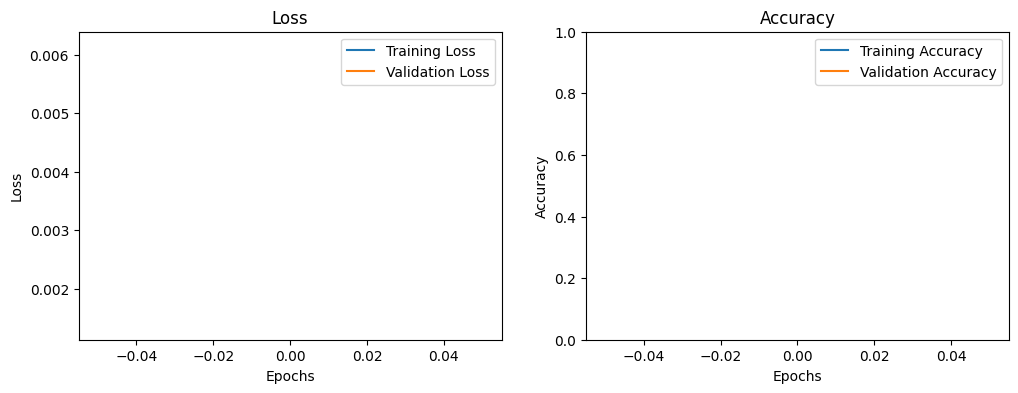

In [ ]:
history_df = pd.DataFrame(history.history)
plot_learning_curves(history_df)

In [ ]:
# prompt: 드라이브에 저장된 모델 불러오기
model_load_path = os.path.join('/content/drive/My Drive/models', 'model_mobilenetv2.keras')
loaded_model = tf.keras.models.load_model(model_load_path)

# 불러온 모델 확인
loaded_model.summary()

# 불러온 모델 평가
loss, accuracy = loaded_model.evaluate(test_generator)
print(f"✅ Loaded model Test loss: {loss}")
print(f"✅ Loaded model Test accuracy: {accuracy}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,253,359 (12.41 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 663,584 (2.53 MB)

94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 306ms/step - accuracy: 0.9984 - loss: 0.0112
✅ Loaded model Test loss: 0.011214232072234154
✅ Loaded model Test accuracy: 0.9980000257492065


In [ ]:
# 데이터 예측
# Get the true classes (ground truth) from the test generator
true_classes = test_generator.classes

# Predict probabilities for each class using the model
predictions = loaded_model.predict(test_generator)

# Convert probabilities to predicted class indices (select the class with the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

test_labels=test_generator.class_indices.keys()

94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 318ms/step


In [ ]:
# Generate the classification report
# target_names assigns human-readable class names from the test generator
report = classification_report(true_classes, predicted_classes, target_names=test_labels)
print(report)

              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00       200
Bitter_Gourd       1.00      0.99      1.00       200
Bottle_Gourd       1.00      0.99      1.00       200
     Brinjal       1.00      1.00      1.00       200
    Broccoli       1.00      1.00      1.00       200
     Cabbage       1.00      1.00      1.00       200
    Capsicum       1.00      1.00      1.00       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.99      1.00      1.00       200
    Cucumber       1.00      0.99      1.00       200
      Papaya       1.00      1.00      1.00       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       1.00      0.99      1.00       200
      Radish       1.00      1.00      1.00       200
      Tomato       1.00      0.99      0.99       200

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00   

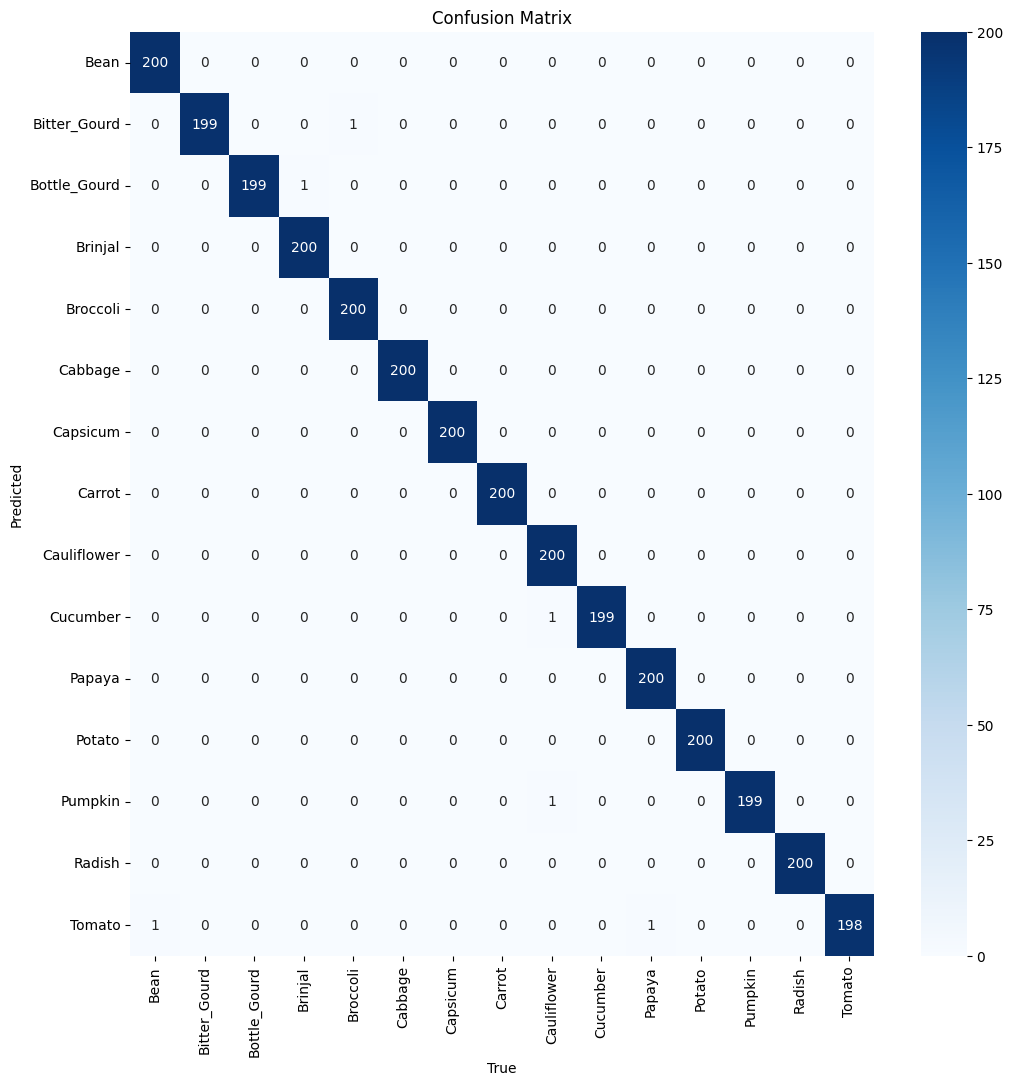

In [ ]:
plt.figure(figsize=(12,12))
cm=confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues", xticklabels=test_labels,yticklabels=test_labels)
plt.title("Confusion Matrix")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()